In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [35]:
# imports
import os
import pandas as pd
import numpy as np

import random

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

import nltk
#file for punkt splitter
nltk.download('punkt');
#file for vader sentiment
nltk.download('vader_lexicon');

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<br><br>

## Data loading/collection

In [3]:
series_len = 100
mask_value = -10
max_len = 0

def text_to_sentiments(text):
    sentences = nltk.tokenize.sent_tokenize(text)
    scores = [ sia.polarity_scores(s)['compound'] for s in sentences] #list of compound score per sentence
    
    if len(scores) < series_len:
        t  = series_len - len(scores)
        scores = np.pad(scores, (t, 0), mode='constant', constant_values=mask_value)
        scores = scores.reshape((series_len, 1))
    else:
        scores = np.array(scores[(-1*series_len):])
        scores = scores.reshape((series_len, 1))
        
    return scores

In [4]:
df = None
try:
    df = pd.read_csv(os.path.join('out', 'truefake_series.csv'))
    print('Succesfully loaded data')
except FileNotFoundError:
    print('ERROR: Couldn\'t find data, will start building it now...')
    dataset_path_true = os.path.join("sources", "ISOT", "True.csv")
    dataset_path_fake = os.path.join("sources", "ISOT", "Fake.csv")

    dataset_load_true = pd.read_csv(dataset_path_true, encoding='utf-8') # make sure to use the right encoding
    dataset_load_fake = pd.read_csv(dataset_path_fake, encoding='utf-8') 
    
    df_T = pd.DataFrame(columns = ['scores', 'veracity'])
    df_F = pd.DataFrame(columns = ['scores', 'veracity'])

    df_T['scores'] = dataset_load_true.text.apply(text_to_sentiments)
    df_T['veracity'] = 1

    df_F['scores'] = dataset_load_fake.text.apply(text_to_sentiments)
    df_F['veracity'] = 0

    df = pd.concat([df_T,df_F], ignore_index=True)
    df = df[df['scores'].map(lambda d: len(d)) > 0]
    df.reset_index(drop = True, inplace=True)
    
    df = pd.concat([df_T,df_F], ignore_index=True)
    df = df[df['scores'].map(lambda d: len(d)) > 0]
    df.reset_index(drop = True, inplace=True)
    
    df.to_csv(os.path.join('out', 'truefake_series.csv'), index=False)
    
finally:
    display(df)

ERROR: Couldn't find data, will start building it now...


,scores,veracity
0,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
1,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
2,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
3,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
4,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
...,...,...
44893,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0
44894,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0
44895,"[[-0.0772], [-0.9646], [-0.9522], [0.4272], [0...",0
44896,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0


<br><br>
## Splitting data

In [5]:
def train_test_split(df_in, test_size, shuffle=True):
    
    if shuffle:
        df_in = df_in.sample(frac=1).reset_index(drop=True)
    
    mask_test = np.random.rand(len(df_in)) < test_size # the sample is large enough to probably not care about proper division
    
    train = df_in[~mask_test]
    test = df_in[mask_test]
    
    X_train = np.array(train['scores'].tolist())
    y_train = np.array(train['veracity'].tolist())
    
    X_test = np.array(test['scores'].tolist())
    y_test = np.array(test['veracity'].tolist())
    
    return (X_train, y_train), (X_test, y_test)

In [6]:
# z = np.array([0.1,0.2,0.3])
# z = z.reshape(3, 1)
# print(z,'\n')
# x = pd.DataFrame({'A': [z,z,z,z]})
# print(x,'\n')
# y = np.array(x['A'].to_list())
# print(y,'\n',y.shape)

In [25]:
np.random.seed(100)
random.seed(100)

# # turn T/F labels into 1/0
# d = {'T': 1, 'F':0}
# df['veracity'] = df['veracity'].map(d)

(X_train, y_train), (X_test, y_test) = train_test_split(df, test_size = 0.4)

print("train: ",len(X_train), len(y_train),
     "\ntest: ",len(X_test), len(y_test),
     "\ntest/total: {:0.3f} %".format(len(X_test)/(len(X_test)+len(X_train)))
    )

train:  26825 26825 
test:  18073 18073 
test/total: 0.403 %


<br><br>

## Building the model

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [30]:
model = None

model = Sequential()

model.add(Masking(mask_value=mask_value,
                  input_shape=(series_len, 1)))

model.add(LSTM(100,return_sequences=True))

model.add(LSTM(50))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_12 (Masking)         (None, 100, 1)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=50)

Epoch 1/20
537/537 [==============================] - 76s 141ms/step - loss: 0.6857 - accuracy: 0.5536 - val_loss: 0.6775 - val_accuracy: 0.5734
Epoch 2/20
537/537 [==============================] - 71s 133ms/step - loss: 0.6728 - accuracy: 0.5842 - val_loss: 0.6774 - val_accuracy: 0.5867
Epoch 3/20
537/537 [==============================] - 70s 130ms/step - loss: 0.6676 - accuracy: 0.5956 - val_loss: 0.6662 - val_accuracy: 0.5954
Epoch 4/20
537/537 [==============================] - 70s 131ms/step - loss: 0.6603 - accuracy: 0.6014 - val_loss: 0.6638 - val_accuracy: 0.5935
Epoch 5/20
537/537 [==============================] - 70s 130ms/step - loss: 0.6553 - accuracy: 0.6055 - val_loss: 0.6550 - val_accuracy: 0.6068
Epoch 6/20
537/537 [==============================] - 70s 131ms/step - loss: 0.6504 - accuracy: 0.6149 - val_loss: 0.6545 - val_accuracy: 0.6070
Epoch 7/20
537/537 [==============================] - 72s 133ms/step - loss: 0.6464 - accuracy: 0.6158 - val_loss: 0.6489 - val_ac

In [32]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.11%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


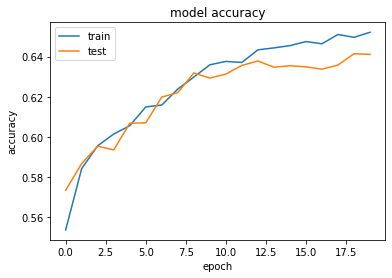

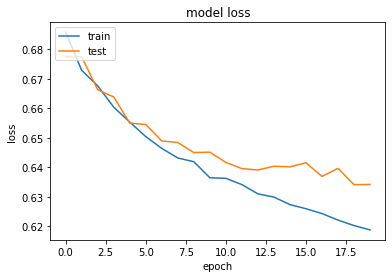

In [33]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()